<a href="https://colab.research.google.com/github/mehmeteminuludag/ImageCaptioning/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files #yarışmada sunulan verileri çekmek için kaggle bağlantısı
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download obss-intern-competition-2025
!unzip obss-intern-competition-2025.zip -d obss-intern-competition-2025

Saving kaggle.json to kaggle (1).json
obss-intern-competition-2025.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  obss-intern-competition-2025.zip
replace obss-intern-competition-2025/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os #kullanılan kütüphaneler
import csv
import math
import requests
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
from transformers import T5Tokenizer
import torch.nn.functional as F
from torch.optim import AdamW
from torchvision.models import swin_s
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
from transformers import AutoTokenizer


with open('/content/obss-intern-competition-2025/train.csv', newline='', encoding='utf-8') as csvfile: #ilgili verilerin bilgilerinin olduğu csv dosyaları
    reader = csv.DictReader(csvfile)
    train_csv = [row for row in reader]
with open('/content/obss-intern-competition-2025/test.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    test_csv = [row for row in reader]

train_path = '/content/obss-intern-competition-2025/train/train' #ilgili train ve test yolları
test_path = '/content/obss-intern-competition-2025/test/test'


def tokenize_caption(caption, tokenizer, max_length=30):
    encoded = tokenizer.encode(caption, max_length=max_length, padding='max_length', truncation=True) #captionları düzleme dönüştürmek için tokenizer encode işlemi yapılıyor
    return torch.tensor(encoded)

class read_images(Dataset):
  def __init__(self,images_path,csv_list,transform,is_test=False):
    self.datas = []
    self.transform = transform
    self.is_test = is_test
    for label in csv_list:

      image_filename = label["image_id"]
      if not image_filename.endswith(".jpg"):
        image_filename += ".jpg"

      image_path = os.path.join(images_path, image_filename)
      if self.is_test:
                image_name_no_ext = os.path.splitext(image_filename)[0]
                self.datas.append((image_path, image_name_no_ext))
      else:
          caption = label["caption"]
          self.datas.append((image_path, caption))



  def __len__(self):
    return len(self.datas)

  def __getitem__(self, idx):
    if self.is_test:
        image_path,image_name = self.datas[idx]
    else:
        image_path, caption = self.datas[idx]

    image = Image.open(image_path).convert("RGB")

    if self.transform:
        img = self.transform(image)
    else:
        img = image

    if self.is_test:
        return img,image_name
    else:
        return img, tokenize_caption(caption, tokenizer, max_length=30)

resize_transform = transforms.Compose([ #test verisi için sadece resize ve normalizasyon yapılıyor
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_transform = transforms.Compose([ #veri çeşitliliğinin artması için çeşitli veri artırma teknikleri kullanılıyor
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
full_dataset = read_images(train_path,train_csv,resize_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])


train_dataset = Subset(full_dataset, train_indices)
train_dataset.dataset.transform = train_transform

val_dataset = Subset(full_dataset, val_indices)
test_dataset = read_images(test_path,test_csv,resize_transform,is_test=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def test_model(model, test_loader, device, out_csv_path, tokenizer,temperature,k):
    model.eval()
    model.to(device)

    results = []

    for data in tqdm(test_loader):
        images, image_names = data
        images = images.to(device)
        for i in range(images.size(0)):
            caption =model.generate_caption(images[i], tokenizer,temperature=temperature,k=k)
            results.append({'image_id': image_names[i], 'caption': caption})

    df = pd.DataFrame(results)
    df.to_csv(out_csv_path, index=False)
    print(f"Submission file saved to: {out_csv_path}")


def train_model(model, epochs, optimizer, criterion, train_loader,val_loader, device,tokenizer,scheduler=None):
    scaler = torch.amp.GradScaler()
    for epoch in range(epochs):
        # Eğitim aşaması
        model.to(device)
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0,

        train_pbar = tqdm(
            enumerate(train_loader),
            total=len(train_loader),
            desc=f"Epoch {epoch+1}/{epochs} • Train",
            dynamic_ncols=True,
            position=0
        )
        for step, train_batch in train_pbar:
          images, captions = train_batch
          images = images.to(device)
          captions = captions.to(device)
          optimizer.zero_grad()

          with torch.cuda.amp.autocast():
                outputs = model(images, captions[:, :-1])
                outputs = outputs.reshape(-1, outputs.size(-1))
                targets = captions[:, 1:].reshape(-1)

                loss = criterion(outputs,targets)
                loss = loss.float()
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

          preds = outputs.argmax(dim=1)
          running_correct += (preds == targets).sum().item()
          running_total   += targets.numel()
          running_loss    += loss.item() * targets.numel()

          train_pbar.set_postfix(
                loss = running_loss / running_total,
                acc  = running_correct / running_total
            )
        epoch_train_loss = running_loss / running_total
        epoch_train_acc  = running_correct / running_total

        model.eval()
        #Doğrulama aşaması
        val_loss, val_correct, val_total = 0.0, 0, 0


        with torch.no_grad():
            for images, captions in val_loader:
                images = images.to(device)
                captions = captions.to(device)
                outputs = model(images, captions[:, :-1])
                outputs = outputs.reshape(-1, outputs.size(-1))
                targets = captions[:, 1:].reshape(-1)
                loss = criterion(outputs, targets)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == targets).sum().item()
                val_total   += targets.numel()
                val_loss    += loss.item() * targets.numel()


        epoch_val_loss = val_loss / val_total
        epoch_val_acc  = val_correct / val_total
        if scheduler is not None:
          scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} — Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")


In [ ]:
class VisualPositionalEncoding2D(nn.Module):
    def __init__(self, num_patches_h, num_patches_w, embed_dim):
        super().__init__()
        self.row_embed = nn.Embedding(num_patches_h, embed_dim)
        self.col_embed = nn.Embedding(num_patches_w, embed_dim)

    def forward(self, B, H, W, device):
        i = torch.arange(H, device=device)
        j = torch.arange(W, device=device)
        x_emb = self.col_embed(j)  # (W, D)
        y_emb = self.row_embed(i)  # (H, D)

        pos = y_emb.unsqueeze(1) + x_emb.unsqueeze(0)  # (H, W, D)
        pos = pos.flatten(0, 1).unsqueeze(0).repeat(B, 1, 1)  # (B, H*W, D)
        return pos

class SwinWithTransformerDecoder(nn.Module):
  def __init__(self,dim_feedforward,vocab_size,max_len,embed_size,num_layers=1,dropout=0,device='cpu', h=8, w=8):
    super().__init__()
    self.device = device
    self.num_layers=num_layers
    self.dropout=dropout
    self.max_len=max_len
    self.embed_size = embed_size
    self.dim_feedforward = dim_feedforward
    self.vocab_size = vocab_size

    self.visual_pos_emb = VisualPositionalEncoding2D(h, w, embed_size)

    self.swin = swin_s(weights="IMAGENET1K_V1")
    self.swin.features[0][0]._modules['0'] = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=16, stride=16)
    self.swin = nn.Sequential(*list(self.swin.children())[:-3])

    self.encoder_proj = nn.Linear(768, self.embed_size)

    decoder_layer= nn.TransformerDecoderLayer(
        d_model=self.embed_size,
        nhead=8,
        dim_feedforward=self.dim_feedforward,
        dropout=self.dropout)
    self.token_emb = nn.Embedding(self.vocab_size, self.embed_size)
    self.pos_emb   = nn.Embedding(self.max_len,   self.embed_size)
    self.decoder = nn.TransformerDecoder(decoder_layer,self.num_layers)
    self.fc_out  = nn.Linear(self.embed_size, self.vocab_size)

  def forward(self,x,l):
    x = self.swin(x)
    batch_size, feat_dim, h, w = x.shape
    B, T = l.shape


    x = x.flatten(2).permute(0, 2, 1).contiguous()
    x=self.encoder_proj(x)
    x = x.to(torch.float32)
    pos_emb = self.visual_pos_emb(B, h, w, self.device)
    x = x + pos_emb


    x = x.permute(1, 0, 2)
    pos = torch.arange(T, device=self.device).unsqueeze(0).expand(B, T)
    pos = pos.to(torch.int32)

    tgt = self.token_emb(l) + self.pos_emb(pos)

    tgt_reshaped = tgt.permute(1, 0, 2)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(T).to(self.device)

    dec_out = self.decoder(tgt_reshaped, x, tgt_mask=tgt_mask)

    logits = self.fc_out(dec_out)
    logits = logits.permute(1, 0, 2)
    return logits

  def generate_caption(self, image, tokenizer, start_token='[CLS]', end_token='[SEP]', temperature=1.0,k=50):
    self.eval()
    image = image.unsqueeze(0).to(self.device)

    start_id = tokenizer.convert_tokens_to_ids(start_token)
    end_id = tokenizer.convert_tokens_to_ids(end_token)

    seq = [start_id]

    for _ in range(self.max_len):
        input_ids = torch.tensor([seq], device=self.device)
        with torch.no_grad():
            outputs = self(image, input_ids)
            logits = outputs[:, -1, :] / temperature #-1 ile sonuncu kelimeyi oluşturcak bilgileri alıyoruz
            topk_logits, topk_indices = torch.topk(logits, k) #top k ve temperature ile decode edilcek verinin tutarlı olmasını hedefliyoruz
            probs = F.softmax(topk_logits, dim=-1)
            sampled_index = torch.multinomial(probs, 1)
            next_token_id = topk_indices[0, sampled_index].item()

        seq.append(next_token_id)
        if next_token_id == end_id:
            break

    caption = tokenizer.decode(seq, skip_special_tokens=True)
    return caption

In [ ]:
url = "https://huggingface.co/mehmmeteminuludag/SwinWithTransformerDecoder/resolve/main/my_model.pth" #raporda bahsedilen 3.2 modelin eğitilmiş ağırlıkları alınıyor
output_path = "my_model.pth"

with open(output_path, "wb") as f:
    f.write(requests.get(url).content)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = tokenizer.vocab_size
dim_feedforward = 512
embed_size=512
max_len=30
num_layers = 8
dropout = 0.2
model = SwinWithTransformerDecoder(dim_feedforward,vocab_size,max_len, embed_size, num_layers,dropout,device) #modelimizdeki parametreleri tanımlayıp modeli oluşturuyoruz
checkpoint = torch.load(output_path, map_location="cuda")
model.load_state_dict(checkpoint["model_state_dict"],strict=False)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer  = torch.optim.AdamW(model.parameters(), lr=1e-4,weight_decay=5e-5)
warmup_epochs  = 2
total_epochs   = 10

def lr_lambda(current_epoch):
    if current_epoch < warmup_epochs:
        return (current_epoch + 1) / warmup_epochs
    progress = (current_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda) # eğitimde optimizer optimizasyonunu sağlamak için scheduler kullanıyoruz

In [ ]:
epochs=5 # yeni eklediğimiz 2 boyutlu embedding ile tekrar eğitim yapıyoruz
train_model(model, epochs, optimizer, criterion, train_loader, val_loader, device, tokenizer,scheduler)

In [ ]:
for name, param in model.swin.named_parameters(): #stage 6 ve öncesi donduruluyor
    if name.startswith("swin.0.7"):
        param.requires_grad = True
    elif name.startswith("1.weight"):
      param.requires_grad = True
    elif name.startswith("1.bias"):
      param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
#decoderın daha iyi eğitilmesi için encoder parametreleri dondurulup tekrar eğitiliyor
epochs=5
train_model(model, epochs, optimizer, criterion, train_loader, val_loader, device, tokenizer,scheduler)

In [ ]:
#test etmek için yukardaki blokları çalıştırmaya ihtiyaç duymadan kütüphane tanımları,veri tanımları ve model sınıfını tanımlayıp bu blok ile modeli kullanmaya hazır hale getiriyoruz


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = tokenizer.vocab_size
dim_feedforward = 512
embed_size=512
max_len=30
num_layers = 8
dropout = 0.35

url = "https://huggingface.co/mehmmeteminuludag/SwinWithTransformerDecoder/resolve/main/swinwithtransformerdecoder.pth" #modelin son halinin ağırlıkları 'swinwithtransformerdecoder' ismi ile hugging face e daha sonra kullanılabilirlik açısından kaydedildi
output_path = "last_model.pth"

with open(output_path, "wb") as f:
    f.write(requests.get(url).content)
checkpoint = torch.load(output_path, map_location="cuda")
model = SwinWithTransformerDecoder(dim_feedforward,vocab_size,max_len, embed_size, num_layers,dropout,device)
model.load_state_dict(checkpoint["model_state_dict"],strict=False)

<All keys matched successfully>

In [ ]:
test_model(model,test_loader,device,"submission.csv",tokenizer,temperature=0.7,k=15) #test görsellerinden caption üretilip "submission.csv" ismiyle istenilen formatta kaydediliyor

100%|██████████| 59/59 [54:52<00:00, 55.80s/it]

Submission file saved to: submission.csv


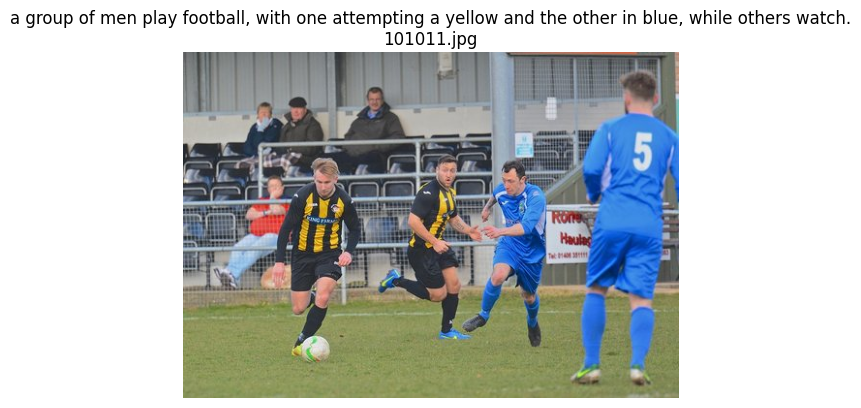

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
image_name="101011.jpg"
example_image_path = '/content/obss-intern-competition-2025/test/test/'+image_name  #örnek görsel ile caption-image kıyaslaması
image = Image.open(example_image_path).convert("RGB")
image_tensor = resize_transform(image).to(device)

model.to(device)
model.eval()
caption = model.generate_caption(image_tensor, tokenizer,temperature=0.7,k=15)

plt.imshow(image)
plt.title(caption+"\n"+image_name)
plt.axis('off')
plt.show()
